In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plot inside the notebook rather than in a new window
%matplotlib inline

In [45]:
# Data loading and cleaning

In [46]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

df = pd.concat([df_train, df_test], sort=False)

In [47]:
df.shape

(1309, 12)

In [48]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
df['Sex'] = df['Sex'].map({
    'male': 0,
    'female': 1
})

In [51]:
df = df \
    .drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked']) \
    .apply(pd.to_numeric, errors='ignore') \
    .fillna(df.mean()) \

In [52]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0.0,3,0,22.0,1,0,7.2500
1,2,1.0,1,1,38.0,1,0,71.2833
2,3,1.0,3,1,26.0,0,0,7.9250
3,4,1.0,1,1,35.0,1,0,53.1000
4,5,0.0,3,0,35.0,0,0,8.0500


In [95]:
# Correlation fun

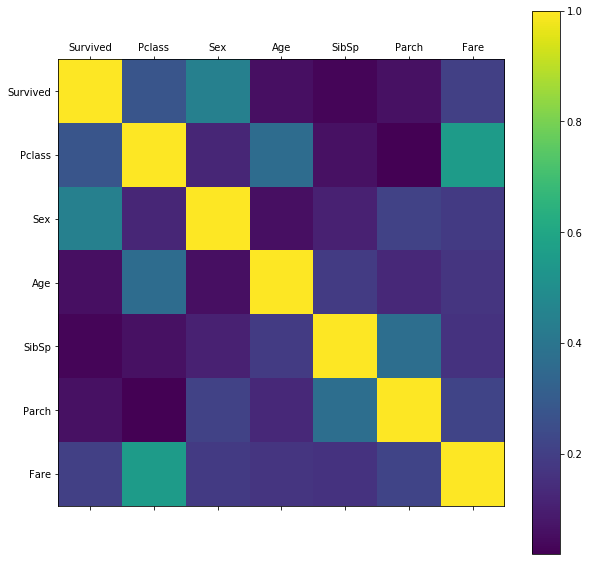

In [68]:
def plot_correlation(dataset):
    """
    Plots a correlation graph for a dataset. Look ma I can print 'pretty' graphs.
    """
    _, axis = plt.subplots(
        figsize=(10,10)
    )
    
    corr_tab = dataset.corr().apply(np.abs)
    
    plot = axis.matshow(corr_tab)
    plt.xticks(range(len(corr_tab.columns)), corr_tab.columns)
    plt.yticks(range(len(corr_tab.index)), corr_tab.index)
    plt.colorbar(plot)


plot_correlation(df.drop(columns='PassengerId'))


for column in df.drop(columns='Survived'):
    _, p_val = pearsonr(df['Survived'], df[column])
    print(f'Correlation p-value for {column}: {p_val} - {p_val < 0.05}')

Correlation p-value for PassengerId: 0.9190524537596824 - False
Correlation p-value for Pclass: 9.139822398794265e-25 - True
Correlation p-value for Sex: 2.2242639506698934e-65 - True
Correlation p-value for Age: 0.03418254716734052 - True
Correlation p-value for SibSp: 0.26476799749857377 - False
Correlation p-value for Parch: 0.02328288168086692 - True
Correlation p-value for Fare: 9.561445864380443e-14 - True
